In [ ]:
#!/usr/bin/python

import json,requests
import pandas as pd
import numpy as np
import enum
from pandas import json_normalize
from datetime import datetime

In [ ]:
# Constant variables
SERVER_INCAPSULA = "my.incapsula.com"
PAGE_SIZE = 100  # The number of objects to return in the response. Defaults to 50. Maximum is 100.
PAGE_NUM = 0 # The page to return starting from 0. Default to 0.

class SIZE_UNIT(enum.Enum):
    BYTES = 1
    KB = 2
    MB = 3
    GB = 4

In [ ]:
# To convert bytes into KB, MB GB 
def conv_bandwith(size_in_bytes, unit):
    if unit == SIZE_UNIT.KB:
        return size_in_bytes/1024
    elif unit == SIZE_UNIT.MB:
        return size_in_bytes/(1024*1024)
    elif unit == SIZE_UNIT.GB:
        return size_in_bytes/(1024*1024*1024)
    else:
        return size_in_bytes

# Obtain all sites for an account
def getSiteList():
    URI = f"https://{SERVER_INCAPSULA}/api/prov/v1/sites/list"
    params = {'api_id':api_id,'api_key':api_key,'page_size':PAGE_SIZE,'page_num':PAGE_NUM}
    headers = {"Content-type": "application/x-www-form-urlencoded","Accept": "text/plain"}

    response = requests.post(URI, headers=headers, data=params)
    data = response.json()

    site_id_list= []

    for i in data["sites"]:
        site_id_list.append(i["site_id"])

    return data

# Obtain site statistics
def getStats(session, stats_type):
    params = {'api_id':api_id,'api_key':api_key,'site_id':site_id,'stats':stats_type,'time_range':time_range,'start':start_time,'end':end_time}
    headers = {"Content-type": "application/x-www-form-urlencoded","Accept": "text/plain"}

    response = session.post(URI, headers=headers, data=params)
    
    return response.json()

In [ ]:
# Imperva statistics Endpoint
URI = f"https://{SERVER_INCAPSULA}/api/stats/v1"

# Imperva API credentials
api_id = "<API-ID>"
api_key = "<API-KEY>"

# Input dates to retrieve statistics
startDate = "2022-05-12 10:00"
endDate = "2022-05-12 10:00"

# Converting human-readable date/time to miliseconds
time_range = "custom"
start = datetime.strptime(startDate, "%Y-%m-%d %H:%M")
end = datetime.strptime(endDate, "%Y-%m-%d %H:%M")
start_time = str(start.timestamp())[:-2] + "000"
end_time =  str(end.timestamp())[:-2] + "000"

# Setting session for API requests
session = requests.session()

# Getting sites json data
site_list = getSiteList()["sites"]

# Generating Sites DF
dfSites = pd.json_normalize(site_list)
dfSites = dfSites[["site_id", "domain", "account_id", "ips", "active"]]

# Collecting site IDs into list
site_list = dfSites['site_id'].tolist()

# Init list datasets to generate Dataframes
dsVisits = []
dsHits = []
dsBandwidth = []
dsThreats = []

# Iterate through site IDs to get the statistics
for site_id in site_list:
    # Human Visits
    rStats = getStats(session, "visits_timeseries")
    human_visits = rStats["visits_timeseries"][0]["data"]
    dfHumanVisits = pd.DataFrame(human_visits, columns= ["visits_time", "human_visit_cnt"])
    human_tot_visits = sum(dfHumanVisits['human_visit_cnt'])
    # Bots Visits
    bot_visits = rStats["visits_timeseries"][1]["data"]
    dfBotVisits = pd.DataFrame(bot_visits, columns= ["visits_time", "bot_visit_cnt"])
    bot_tot_visits = sum(dfBotVisits['bot_visit_cnt'])
    # Collecting site visit results
    dsVisits.append([site_id, human_tot_visits, bot_tot_visits])

    # Human Hits
    rStats = getStats(session, "hits_timeseries")
    human_hits = rStats["hits_timeseries"][0]["data"]
    dfHumanHits = pd.DataFrame(human_hits, columns= ["hits_time", "human_hit_cnt"])
    human_tot_hits = sum(dfHumanHits['human_hit_cnt'])
    # Bot Hits
    bot_hits = rStats["hits_timeseries"][1]["data"]
    dfBotHits = pd.DataFrame(bot_hits, columns= ["hits_time", "bot_hit_cnt"])
    bot_tot_hits = sum(dfBotHits['bot_hit_cnt'])
    # Collecting site hits results
    dsHits.append([site_id, human_tot_hits, bot_tot_hits])

    # BandWidth
    rStats = getStats(session, "bandwidth_timeseries")
    bandwidth = rStats["bandwidth_timeseries"][0]["data"]
    dfBandwidth = pd.DataFrame(bandwidth, columns= ["bandwidth_time", "bandwidth"])
    # Converting DF column to GB
    if int(len(dfBandwidth)) > 0:
        dfBandwidth['bandwidth'] = dfBandwidth.apply(lambda row: conv_bandwith(row['bandwidth'], SIZE_UNIT.GB), axis=1)
    # Adds Bandwith values
    tot_bandwidth_gb = sum(dfBandwidth['bandwidth'])
    # Collecting Bandwith results
    dsBandwidth.append([site_id, tot_bandwidth_gb])

    # Threats
    rStats = getStats(session, "threats")
    threats = rStats["threats"]
    dfThreats = pd.DataFrame(threats, columns= ["incidents", "status_text", "name"])
    # Iterate through DF rows to collect results by site and threat name
    for idx, th in dfThreats.iterrows():
        # Collecting Threats results
        dsThreats.append([site_id, th["name"], th["incidents"]])

In [ ]:
## Generating DFs based on dataset lists
dfVisits = pd.DataFrame(dsVisits, columns = ['site_id', 'human_tot_visits', 'bot_tot_visits'])
dfHits = pd.DataFrame(dsHits, columns = ['site_id', 'human_tot_hits', 'bot_tot_hits'])
dfBandwithGB = pd.DataFrame(dsBandwidth, columns = ['site_id', 'tot_bandwidth_gb'])
dfThreats = pd.DataFrame(dsThreats, columns = ['site_id', 'threat', 'incidents'])
# Converting rows as column headers for Threats
dfThreats = dfThreats.pivot_table(values='incidents', index=dfThreats.site_id, columns='threat', aggfunc='last')
# Reseting dfThreats index (optional)
dfThreats.reset_index(inplace=True)

In [ ]:
# Merging all Dfs together
dfSites = pd.merge(dfSites, dfVisits, on="site_id")
dfSites = pd.merge(dfSites, dfHits, on="site_id")
dfSites = pd.merge(dfSites, dfBandwithGB, on="site_id")
dfSites = pd.merge(dfSites, dfThreats, how="left", on="site_id")

In [ ]:
# Showing final DataFrame
print(dfSites.to_string())

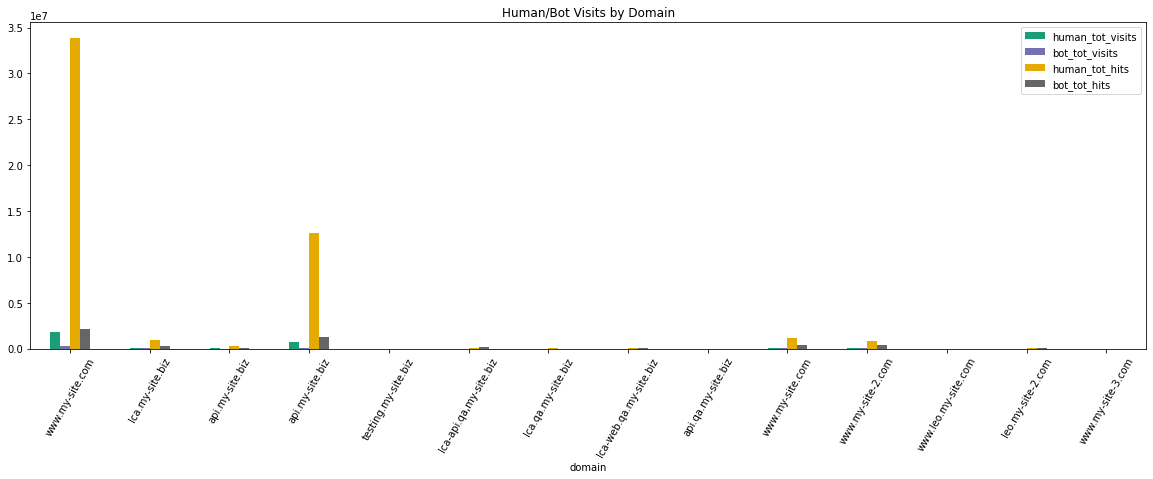

In [7]:
dfSites.plot.bar(x="domain", 
            y=["human_tot_visits", "bot_tot_visits", "human_tot_hits", "bot_tot_hits"], 
            rot=60, title="Human/Bot Visits by Domain", 
            cmap='Dark2', 
            stacked=False, 
            figsize= (20,6));